# **Exploratory Data Analysis**

Import Packages

In [1]:
import pandas as pd
pd.set_option('display.width', 1000)

import numpy as np
import yfinance as yf

# Visualization
import matplotlib.pyplot as plt

from torchinfo import summary

from sklearn.preprocessing import StandardScaler

import joblib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


#--- Starting Here ---#

In [2]:
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [3]:
SOXX = 'SOXX'
soxx_data = yf.download(SOXX, start='2012-01-01', end='2024-01-01')

soxx_data.reset_index(inplace=True)

soxx_data['RSI'] = calculate_rsi(soxx_data['Close'], window=14)
soxx_data['Return'] = ((soxx_data['Close'] - soxx_data['Open']) / soxx_data['Open'])
soxx_data['SMA_20'] = soxx_data['Close'].rolling(window=20).mean()
#soxx_data['Bollinger_Upper'] = soxx_data['SMA_20'] + (soxx_data['Close'].rolling(window=20).std() * 2)
#soxx_data['Bollinger_Lower'] = soxx_data['SMA_20'] - (soxx_data['Close'].rolling(window=20).std() * 2)
soxx_data = soxx_data[['High', 'Low', 'Volume', 'Open', 'Close', 'Return','SMA_20', 'RSI']]

# Normalize the data
scaler = StandardScaler()


print(len(soxx_data.columns))
soxx_data_scaled = scaler.fit_transform(soxx_data[['High', 'Low', 'Volume', 'Open', 'Close', 'SMA_20', 'Return', 'RSI']])
soxx_data_scaled = pd.DataFrame(soxx_data_scaled, columns=soxx_data.columns[:])
#soxx_data_scaled['RSI'] = soxx_data['RSI'].values

soxx_data_scaled.dropna(inplace=True)

soxx_data.dropna(inplace=True)

soxx_data.to_csv("soxxData.csv", index=False)

soxx_data_scaled.head()

[*********************100%***********************]  1 of 1 completed

8


Price,High,Low,Volume,Open,Close,Return,SMA_20,RSI
Ticker,SOXX,SOXX,SOXX,SOXX,SOXX,,,
19,-1.019228,-1.021411,-1.002308,-1.018739,-1.020596,-1.036454,-0.454770,0.893688
20,-1.012615,-1.016089,0.036925,-1.016431,-1.013442,-1.034494,0.616995,1.115305
21,-1.011019,-1.011878,-0.438197,-1.012506,-1.011654,-1.032444,0.144295,1.067849
22,-1.006744,-1.007316,-0.680341,-1.007658,-1.006519,-1.030332,0.203862,1.810307
23,-1.009138,-1.010533,-0.924585,-1.007658,-1.010327,-1.028451,-0.613709,1.414618


In [5]:
scaler_path = "scaler.pkl"
joblib.dump(scaler, scaler_path)

['scaler.pkl']

# **Processing**

- create different datasets for different companies
- History sequence length: 60 days in advance
- Output sequence length: 5 days in future

Creating LSTM Dataset

In [6]:
class LSTMdataset(Dataset):
    def __init__(self, data, sequence_length, output_length):
        self.data = data
        self.data_values = self.data.values
        self.targetIDX = data.columns.get_loc('RSI')
        self.sequence_length = sequence_length
        self.output_length = output_length
        self.sample_length = sequence_length + output_length
        
        self.valid_indices = []
        for i in range(len(self.data) - self.sample_length + 1): 
            self.valid_indices.append(i)

    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        if idx >= len(self.valid_indices):
            raise IndexError("Index out of bounds")
        
        dayIDX = self.valid_indices[idx]
        
        history = self.data_values[dayIDX:dayIDX + self.sequence_length]
        forecast = self.data_values[dayIDX + self.sequence_length:dayIDX + self.sample_length, self.targetIDX]
        
        if len(history) != self.sequence_length or len(forecast) != self.output_length:
            raise ValueError(f"Inconsistent sequence length at index {idx}")

        history = torch.tensor(history, dtype=torch.float32)
        forecast = torch.tensor(forecast, dtype=torch.float32)

        return history, forecast


In [8]:
stock_loaders = {}


#-- INFO --#
shuffle = True
batch_size = 32

lstmdataset = LSTMdataset(data=soxx_data_scaled, sequence_length=200, output_length=4)

print(f"Total Length: {len(lstmdataset)}")
train_size = int(len(lstmdataset) * 0.85)
print(train_size)
test_size = int(len(lstmdataset) * 0.15) + 1
print(test_size)
train_dataset, test_dataset = random_split(lstmdataset, lengths=[train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size, shuffle)
test_loader = DataLoader(test_dataset, batch_size, shuffle)

print(f"Combined Loader Length: {len(train_loader) + len(test_loader)}")

print(f"Train Loader Length: {len(train_loader)}")
print(f"Test Loader Length: {len(test_loader)}")

Total Length: 2796
2376
420
Combined Loader Length: 89
Train Loader Length: 75
Test Loader Length: 14


Create Model & Custom Loss Function

In [9]:
class trendLoss(nn.Module):
    def __init__(self, peak_weight):
        super(trendLoss, self).__init__()
        self.weight = peak_weight

    def forward(self, input, target):
        #print(input.shape)
        #print(target.shape)
        mse = torch.mean(torch.square(target - input))
        
        predicted_peaks = torch.argmax(input, dim=1)  
        target_peaks = torch.argmax(target, dim=1)    
        
        mismatched_peaks = (predicted_peaks != target_peaks).float()
        
        peak_penalty = mismatched_peaks.mean() * mse * self.weight

        #endpoint_loss = torch.mean(torch.square(target[2] - input[2]))

        #start_loss = torch.mean(torch.square(target[0] - input[0]))
        
        return mse + peak_penalty #+ endpoint_loss + start_loss

In [10]:
class LSTMRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LSTMRegression, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size, 512, batch_first=True)
        self.lstm2 = nn.LSTM(512, 512, batch_first=True)
        self.lstm3 = nn.LSTM(512, 256, batch_first=True)
        self.dense1 = nn.Linear(256, 128)  
        self.dense2 = nn.Linear(128, 64)
        self.dense3 = nn.Linear(64, output_size)
            
        self.relu = nn.ReLU()

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, (h_n, c_n) = self.lstm3(out)

        out = out[:, -1, :]

        out = self.dense1(out)  
        out = self.relu(out) 

        out = self.dense2(out)
        out = self.relu(out)

        out = self.dense3(out)
        
        return out

Model and specifics instantiations

In [13]:
model = LSTMRegression(input_size=8, output_size=4).to(device)
optimizer = optim.Adam(params=model.parameters(), lr=1e-4)

peak_weight = torch.tensor(0.3)
customLoss = trendLoss(peak_weight)
huberloss = nn.HuberLoss(delta=0.5)
mseLoss = nn.MSELoss()
print(model)

LSTMRegression(
  (lstm1): LSTM(8, 512, batch_first=True)
  (lstm2): LSTM(512, 512, batch_first=True)
  (lstm3): LSTM(512, 256, batch_first=True)
  (dense1): Linear(in_features=256, out_features=128, bias=True)
  (dense2): Linear(in_features=128, out_features=64, bias=True)
  (dense3): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
)


Training Portion

In [14]:
epochs = 100
model.train()
losses = []

for epoch in range(epochs):
    epoch_loss = 0.0
    batch_count = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device).float(), labels.to(device).float()
        
        optimizer.zero_grad()
        logits = model(inputs)

        loss = mseLoss(logits, torch.squeeze(labels))
        losses.append(loss.detach().cpu().numpy())
        epoch_loss += loss.item()
        

        batch_count += 1
        
        loss.backward()
        optimizer.step()

    avg_epoch_loss = epoch_loss / batch_count
    print(f"Epoch: {epoch}, Average Epoch Loss: {avg_epoch_loss:.4f}")


Epoch: 0, Average Epoch Loss: 0.9215
Epoch: 1, Average Epoch Loss: 0.5084
Epoch: 2, Average Epoch Loss: 0.4406
Epoch: 3, Average Epoch Loss: 0.4065
Epoch: 4, Average Epoch Loss: 0.3759
Epoch: 5, Average Epoch Loss: 0.3553
Epoch: 6, Average Epoch Loss: 0.3410
Epoch: 7, Average Epoch Loss: 0.3081
Epoch: 8, Average Epoch Loss: 0.3001
Epoch: 9, Average Epoch Loss: 0.2953
Epoch: 10, Average Epoch Loss: 0.2845
Epoch: 11, Average Epoch Loss: 0.2750
Epoch: 12, Average Epoch Loss: 0.2703
Epoch: 13, Average Epoch Loss: 0.2587
Epoch: 14, Average Epoch Loss: 0.2597
Epoch: 15, Average Epoch Loss: 0.2572
Epoch: 16, Average Epoch Loss: 0.2494
Epoch: 17, Average Epoch Loss: 0.2425
Epoch: 18, Average Epoch Loss: 0.2391
Epoch: 19, Average Epoch Loss: 0.2314
Epoch: 20, Average Epoch Loss: 0.2218
Epoch: 21, Average Epoch Loss: 0.2222
Epoch: 22, Average Epoch Loss: 0.2151
Epoch: 23, Average Epoch Loss: 0.2048
Epoch: 24, Average Epoch Loss: 0.2021
Epoch: 25, Average Epoch Loss: 0.1945
Epoch: 26, Average Epo

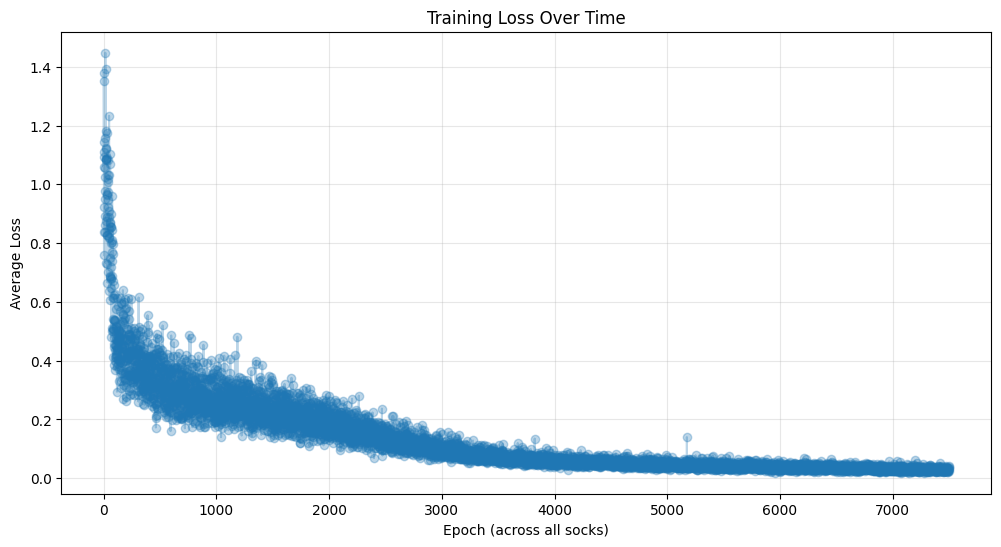

In [17]:
plt.figure(figsize=(12, 6))
xs = np.arange(len(losses))
plt.plot(xs, losses, marker='o', linestyle='-', alpha=0.3)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch (across all socks)')
plt.ylabel('Average Loss')
plt.grid(True, alpha=0.3)
plt.show()

This behaviour is somewhat expected as the "Importance" of the peak penalty is higher, so it optimizes first for the mse and then later the peak penalty

(420, 4)
(420, 4)


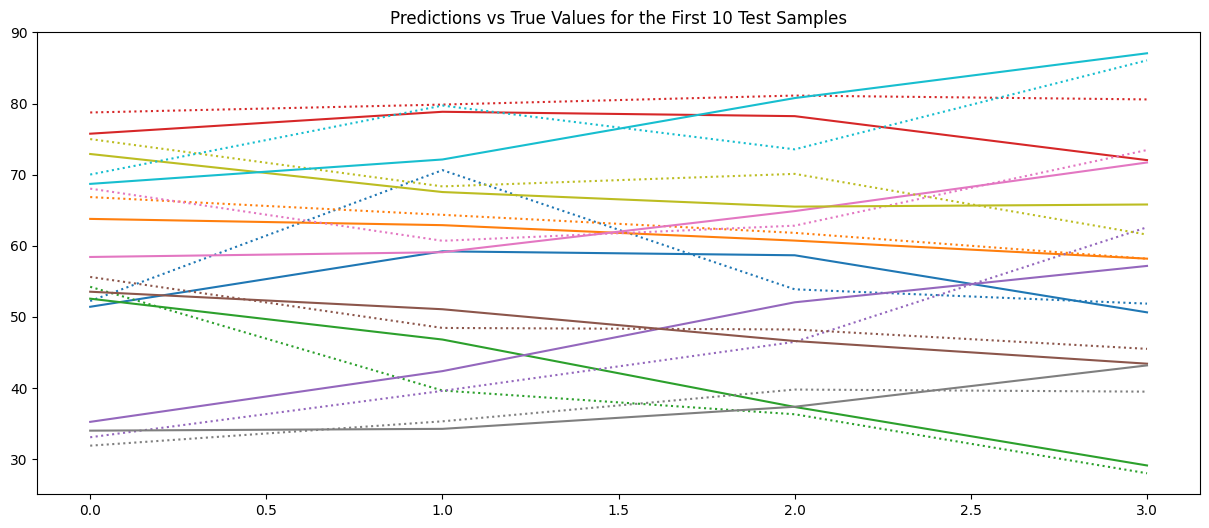

Total Loss: 69.69169616699219


In [19]:
model.eval()
predictions, true_values = [], []
loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        outputs = model(inputs)
        test_loss = customLoss(outputs, torch.squeeze(labels))

        loss += test_loss

        predictions.append(outputs.cpu().numpy())
        true_values.append(labels.cpu().numpy())

# Convert predictions and true values to numpy arrays
predictions = np.concatenate(predictions, axis=0)
true_values = np.squeeze(np.concatenate(true_values, axis=0))

print(predictions.shape)
print(true_values.shape)

rsi_scale = scaler.scale_[7]
rsi_mean = scaler.mean_[7]

unscaled_predictions = (predictions * rsi_scale) + rsi_mean
unscaled_true_values = (true_values * rsi_scale) + rsi_mean

plt.figure(figsize=(15, 6))

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, color in enumerate(default_colors):
    plt.plot(range(4), unscaled_predictions[i], label=f"Predicted {i+1}", linestyle="-", color=color)
    plt.plot(range(4), unscaled_true_values[i], label=f"True {i+1}", linestyle=":", color=color)
plt.title('Predictions vs True Values for the First 10 Test Samples')
plt.show()
                                                                                
print(f"Total Loss: {loss * rsi_scale + rsi_mean}")

In [20]:
torch.save(model.state_dict(), r"predictors/model_dict")
torch.save(model, r"predictors/model")